### IMPORT

In [9]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain 
import folium
import random
import numpy as np
import powerlaw

## MANIPOLAZIONE FILES CSV

In [2]:
df = pd.read_csv('./dataset/treni_modificati.csv') 
df_citta = pd.read_csv('./dataset/df_citta.csv')
df_comuni = pd.read_csv('./dataset/comuni_coordinates.csv')

# CREAZIONE TRENI_SOLO_CITTA.CSV (ARCHI)

colonne_da_tenere = ['stazPart', 'stazArr']
df = df[colonne_da_tenere]
#salva
#df.to_csv('./dataset/treni_solo_citta.csv', index=False)

#CREAZIONE CITTA.CSV (NODI)

# Unisci le due colonne in una singola serie e ottieni i valori unici
df = pd.concat([df['stazPart'], df['stazArr']]).unique()
# Salva
#pd.DataFrame(df, columns=['citta_uniche']).to_csv('./dataset/df_citta.csv', index=False)

#AGGIUNGE LOCATION

colonne_da_tenere = ['DENOMINAZIONE_ITA_ALTRA', 'LAT', 'LON']
df_comuni = df_comuni[colonne_da_tenere]
# Salva 
#df_comuni.to_csv('./dataset/df_comuni.csv', index=False)

# rinomina la colonna per aiutarci in seguito
df_comuni.rename(columns={'DENOMINAZIONE_ITA_ALTRA': 'citta_uniche'}, inplace=True) 
merged_data = pd.merge(df_citta, df_comuni, on='citta_uniche', how='inner') # Merge
# Salva
#pd.DataFrame(merged_data).to_csv('./dataset/merged_data.csv', index=False)


## GRAFO E MISURAZIONI

prova del grafo, utilizzare probebilemte quella sotto e cancellare la sezione di codice che segue

In [ ]:
# Caricamento dei dataset
df_citta = pd.read_csv('./dataset/lista_citta_con_stazione.csv')
df_coppie = pd.read_csv('./dataset/treni_solo_citta.csv')

# Creazione del grafo
G = nx.Graph()

# Mappa per evitare sovrapposizioni
posizioni_usate = {}

for idx, row in df_citta.iterrows():
    # Genera posizione casuale non sovrapposta
    while True:
        x = random.uniform(0, 1)  # Coordinate x casuali tra 0 e 1
        y = random.uniform(0, 1)  # Coordinate y casuali tra 0 e 1
        pos = (x, y)
        if pos not in posizioni_usate.values():
            posizioni_usate[row['citta_uniche']] = pos
            break   
    G.add_node(row['citta_uniche'], pos=pos)

# Aggiunta degli archi (treni da stazPart a stazArr)
for idx, row in df_coppie.iterrows():
    G.add_edge(row['stazPart'], row['stazArr'])

# Rimozione dei cicli
G.remove_edges_from(nx.selfloop_edges(G))

# Layout del grafo
pos = nx.get_node_attributes(G, 'pos')

# Disegno del grafo con migliori caratteristiche estetiche
plt.figure(figsize=(12, 8))
nx.draw(
    G, pos,
    with_labels=True,
    node_color='skyblue',  # Colore dei nodi
    node_size=60,  # Dimensione dei nodi
    font_size=5,  # Dimensione del font delle etichette dei nodi
    font_color='darkblue',  # Colore del font delle etichette
    edge_color='gray',  # Colore degli archi
    width=0.5,  # Larghezza degli archi
    alpha=0.7  # Trasparenza degli archi
)

# Titolo del grafo
plt.title('Grafo delle Città con Stazioni e Connessioni Ferroviarie', fontsize=15)
plt.show()

## LAYOUT DEL GRAFO APPENA DESCRITTO

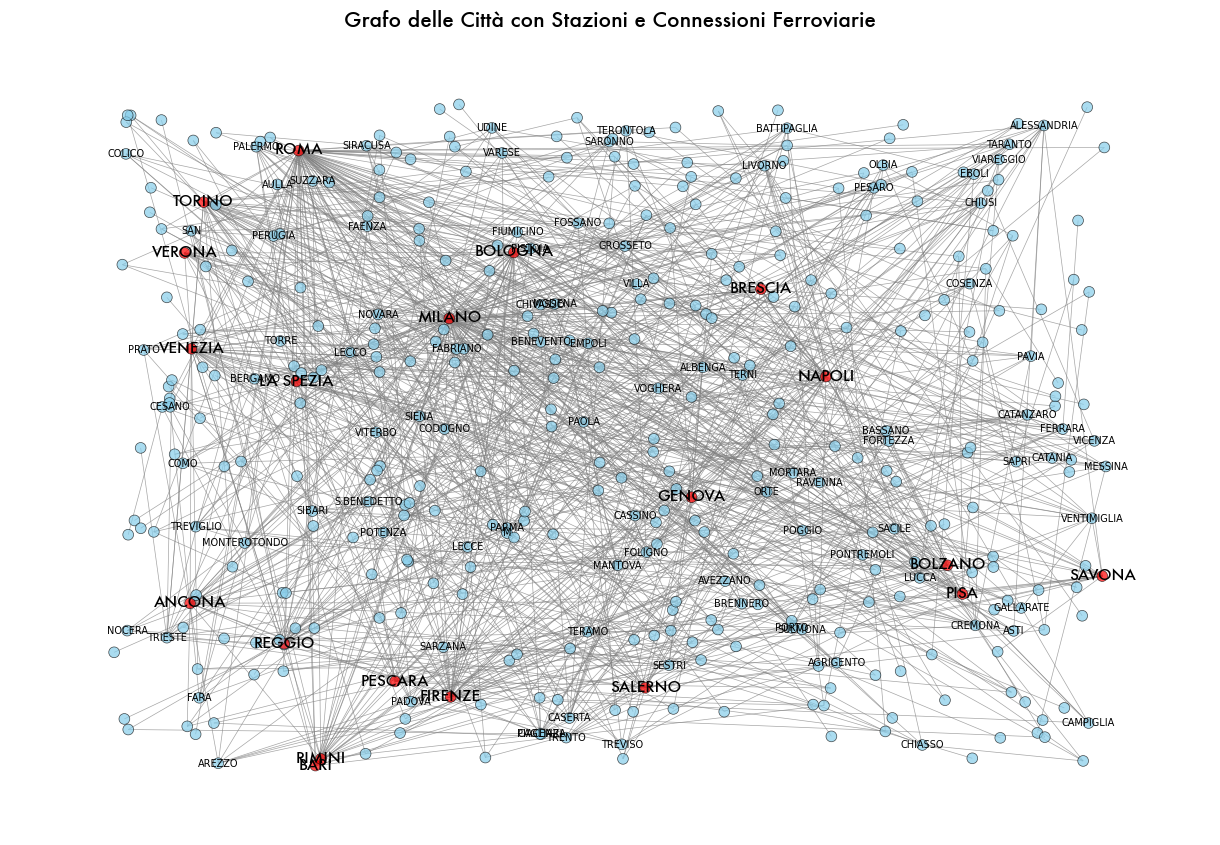

In [3]:
# Caricamento dei dataset
df_citta = pd.read_csv('./dataset/lista_citta_con_stazione.csv')
df_coppie = pd.read_csv('./dataset/treni_solo_citta.csv')

# Creazione del grafo
G = nx.Graph()

# Mappa per evitare sovrapposizioni
posizioni_usate = {}

for idx, row in df_citta.iterrows():
    while True:
        x = random.uniform(0, 1)  # Coordinate x casuali tra 0 e 1
        y = random.uniform(0, 1)  # Coordinate y casuali tra 0 e 1
        pos = (x, y)
        if pos not in posizioni_usate.values():
            posizioni_usate[row['citta_uniche']] = pos
            break   
    G.add_node(row['citta_uniche'], pos=pos)

# Aggiunta degli archi (treni da stazPart a stazArr)
for idx, row in df_coppie.iterrows():
    G.add_edge(row['stazPart'], row['stazArr'])

G.remove_edges_from(nx.selfloop_edges(G))  # Rimozione dei cicli

# Calcolare la degree centrality
degree_centrality = nx.degree_centrality(G)
#calcolo la trharshold come la media della degree centrality
threshold = np.mean(list(degree_centrality.values()))
# Trovare le città con degree centrality sopra la soglia
significant_cities = {node for node, centrality in degree_centrality.items() if centrality > threshold}
# Ordinare i nodi per degree centrality e prendere i primi 20
top_20_cities = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:20]

# Layout del grafo
pos = nx.get_node_attributes(G, 'pos')

# Disegnare il grafo
plt.figure(figsize=(12, 8))
nx.draw(
    G, pos,
    with_labels=False,
    node_color=['red' if node in top_20_cities else 'skyblue' for node in G.nodes()],  # Colore dei nodi
    node_size=60,  # Dimensione dei nodi
    edge_color='gray',  # Colore degli archi
    width=0.5,  # Larghezza degli archi
    alpha=0.7,  # Trasparenza degli archi
    edgecolors='black',  # Colore del bordo dei nodi
    linewidths=0.5  # Spessore del bordo dei nodi
)

# Disegnare le etichette con differenti pesi e font
font_family_top_20 = 'Futura'  # Scegli il font desiderato
font_family = 'Sans-Serif'  # Scegli il font desiderato

labels_bold = {node: node for node in top_20_cities}
labels_normal = {node: node for node in G.nodes() if node not in top_20_cities and node in significant_cities}

nx.draw_networkx_labels(G, pos, labels=labels_bold, font_size=11, font_color='black', font_weight='bold', font_family=font_family_top_20)
nx.draw_networkx_labels(G, pos, labels=labels_normal, font_size=7, font_color='black', font_weight='normal', font_family=font_family)

# Titolo del grafo
plt.title('Grafo delle Città con Stazioni e Connessioni Ferroviarie', fontsize=15, fontweight='bold', fontname='Futura')
plt.show()


### MISURAZIONI SUL GRAFO

In [5]:
# Calcolo delle misurazioni di centralità e altre metriche
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
closeness_centrality = nx.closeness_centrality(G)
clustering_coefficient = nx.clustering(G)
density = nx.density(G)

if nx.is_connected(G):
    avg_path_length = nx.average_shortest_path_length(G)
    diameter = nx.diameter(G)
else:
    avg_path_length = None
    diameter = None

connected_components = list(nx.connected_components(G))
connectedness = len(connected_components)

core_number = nx.core_number(G)
assortativity = nx.degree_assortativity_coefficient(G)
bridges = list(nx.bridges(G))

partition = community_louvain.best_partition(G)
modularity = community_louvain.modularity(partition, G)

# Stampa delle metriche
print("Degree Centrality:", degree_centrality)
print("Betweenness Centrality:", betweenness_centrality)
print("Eigenvector Centrality:", eigenvector_centrality)
print("Closeness Centrality:", closeness_centrality)
print("Clustering Coefficient:", clustering_coefficient)
print("Density:", density)
print("Number of Connected Components:", connectedness)
print("Core Numbers:", core_number)
print("Assortativity:", assortativity)
print("Bridges:", bridges)
print("Comunità rilevate:", partition)
print("Modularità:", modularity)

Degree Centrality: {'MONZA': 0.009592326139088728, 'BOLOGNA': 0.09832134292565947, 'FIRENZE': 0.07913669064748201, 'PUNTA': 0.009592326139088728, 'VENEZIA': 0.08393285371702637, 'MILANO': 0.21822541966426856, 'LA SPEZIA': 0.05275779376498801, 'CASERTA': 0.03357314148681055, 'PALERMO': 0.026378896882494004, 'ROMA': 0.18944844124700239, 'NOVATE': 0.009592326139088728, 'CASSINO': 0.01199040767386091, 'BRINDISI': 0.004796163069544364, 'CHIUSI': 0.026378896882494004, 'ANCONA': 0.050359712230215826, 'CALTANISSETTA': 0.007194244604316546, 'BELLUNO': 0.009592326139088728, 'S.BENEDETTO': 0.014388489208633093, 'FOLIGNO': 0.02398081534772182, 'CIVITAVECCHIA': 0.004796163069544364, 'ALESSANDRIA': 0.028776978417266185, 'NOVARA': 0.03357314148681055, 'STABIO': 0.004796163069544364, 'VARESE': 0.016786570743405275, 'FAENZA': 0.01199040767386091, 'PORTOGRUARO': 0.009592326139088728, 'SAVONA': 0.03836930455635491, 'PARMA': 0.026378896882494004, 'TORINO': 0.08872901678657073, 'CIAMPINO': 0.00959232613908

### CENNI TEORICI (PERCHE ABBIAMO SCELTO QUELLE METRICHE) DA SCRIVERE NELLA RELAZIONE

In [ ]:
'''

1. Centralità (Degree, Betweenness, Eigenvector, Closeness)
Scopo: Identificare i nodi (comuni) più importanti o influenti nella rete.
Misurazioni:
Degree Centrality: Indica quanti collegamenti ha un nodo. Può rivelare le stazioni ferroviarie con il maggior numero di connessioni dirette.
Betweenness Centrality: Misura il numero di volte che un nodo funge da intermediario nei cammini minimi. Utile per identificare nodi critici che, se rimossi, potrebbero causare disconnessione della rete.
Eigenvector Centrality: Valuta l'importanza di un nodo basata sulla centralità dei suoi vicini. Può identificare le stazioni più influenti in un contesto globale.
Closeness Centrality: Indica quanto un nodo è "vicino" a tutti gli altri nodi. Utile per capire quali stazioni hanno accesso rapido al resto della rete.

2. Coefficienti di Clustering e Densità
Scopo: Analizzare la coesione e la compattezza della rete.
Misurazioni:
Clustering Coefficient: Misura la tendenza dei nodi a formare cluster o gruppi. Utile per capire quanto la rete è segmentata in comunità o sub-reti.
Density: Rapporto tra il numero di archi presenti e il numero massimo possibile di archi. Indica quanto la rete è densamente connessa.


3. Analisi delle Componenti Connesse
Scopo: Identificare e analizzare le componenti connesse della rete per capire come la rete potrebbe frammentarsi.
Misurazioni:
Connected Components: Numero di componenti connesse nella rete. Utile per identificare isole o subnet isolate.

4. Core-Periphery Analysis
Scopo: Identificare la struttura core-periphery della rete.
Misurazioni:
Core Number: Utilizzare l'algoritmo di k-core per identificare il nucleo centrale della rete.

5. Assortativity
Scopo: Valutare se nodi con simili proprietà (ad esempio, grado) tendono a collegarsi tra loro.
Misurazioni:
Degree Assortativity Coefficient: Misura la correlazione tra i gradi dei nodi connessi. Può indicare se stazioni centrali tendono a collegarsi con altre stazioni centrali.

6. Modularity e Community Detection
Scopo: Identificare comunità o gruppi di nodi fortemente connessi all'interno della rete.
Misurazioni:
Modularity: Misura la forza della divisione della rete in moduli o comunità. Utilizzando algoritmi di rilevazione delle comunità come Louvain.

'''

## MAPPA DELL'ITALIA 

N.B. se vogliamo cambiare il layout dei nedi nella mappa basta aggiungere un codice personalizzato per il nodo in svg. 

es. non voglio il cerchio rosso ma voglio il triangolo con bordo verde scuro e interno verde chiaro

In [ ]:
df_citta = pd.read_csv('./dataset/merged_data.csv')
df_coppie = pd.read_csv('./dataset/treni_solo_citta.csv')

# Mappa delle città ai loro set di coordinate
citta_coord = {}
for idx, row in df_citta.iterrows():
    citta_coord[row['citta_uniche']] = (row['LAT'], row['LON'])

# mappa centrata sull'Italia con l'importazione del file .geojson trovato online
m = folium.Map(location=[41.8719, 12.5674], zoom_start=6, zoom_control=True, scrollWheelZoom=True)
geojson_data = './italy.geojson'

# Bordo nero delle regioni
folium.GeoJson(
    geojson_data,
    style_function=lambda feature: {
        'color': 'black',
        'weight': 0.7
    }
).add_to(m)

# aggiungere un arco tra le città di partenza e arrivo
def aggiungi_arco(mappa, citta_partenza, citta_arrivo):
    coord_partenza = citta_coord.get(citta_partenza)
    coord_arrivo = citta_coord.get(citta_arrivo)
    
    if coord_partenza and coord_arrivo:
        folium.PolyLine(
            locations=[coord_partenza, coord_arrivo],
            color='grey',
            weight=0.05,
            opacity=1  
        ).add_to(mappa)

# Aggiungi i nodi delle città alla mappa
for idx, row in df_citta.iterrows():
    folium.CircleMarker(
        location=[row['LAT'], row['LON']],
        radius=1,
        color='black',
        fill=True,
        fill_color='black',
        fill_opacity=0.7 
    ).add_to(m)

# Aggiungi gli archi tra le città di partenza e arrivo nel DataFrame delle coppie
for idx, row in df_coppie.iterrows():
    aggiungi_arco(m, row['stazPart'], row['stazArr'])

m

# GRAFICI MISURAZIONI

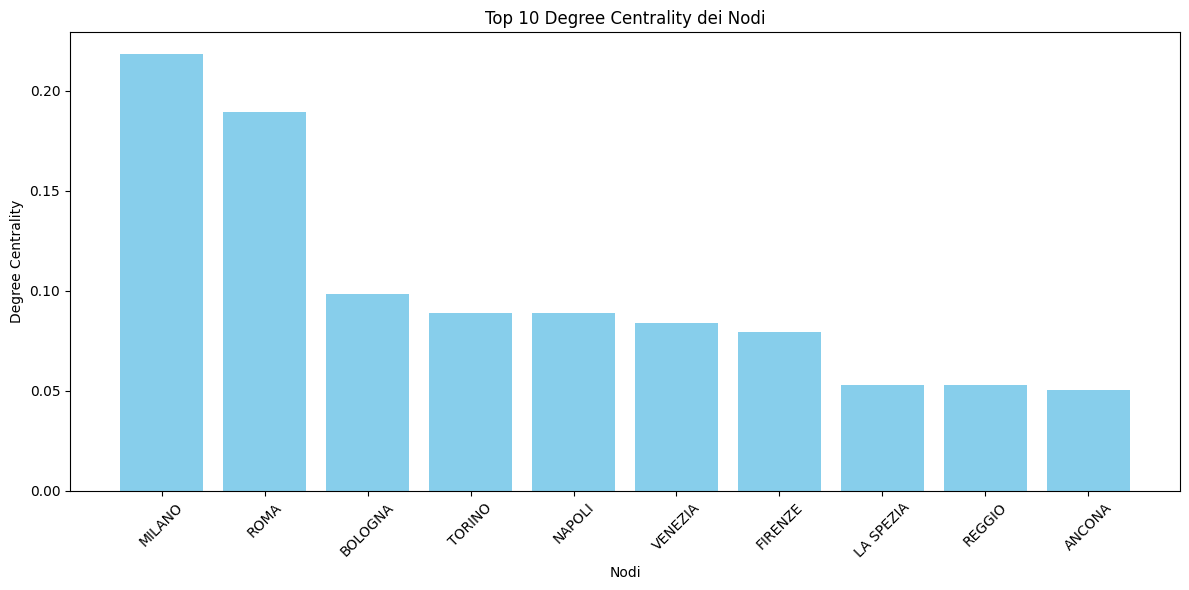

In [6]:
# Ordina i nodi per degree centrality e prendi i primi 10
top_nodes_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
nodes_degree = [node for node, _ in top_nodes_degree]
centrality_values_degree = [value for _, value in top_nodes_degree]

# Plot del grafico a istogramma
plt.figure(figsize=(12, 6))
plt.bar(nodes_degree, centrality_values_degree, color='skyblue')
plt.xlabel('Nodi')
plt.ylabel('Degree Centrality')
plt.title('Top 10 Degree Centrality dei Nodi')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## CALCOLO DELLE DISTRIBUZIONI DELLE CENTRALITà USANDO LA LEGGE DI POTENZA E LA LEGGE DI POTENZA LOGARITMICA

Calculating best minimal value for power law fit
Esponente della legge di potenza (Degree Centrality): 2.9729
p-value del fit della legge di potenza (Degree Centrality): 0.0601
Log-likelihood ratio test between power law and lognormal (Degree Centrality): -1.8070
p-value for the log-likelihood ratio test (Degree Centrality): 0.0066


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


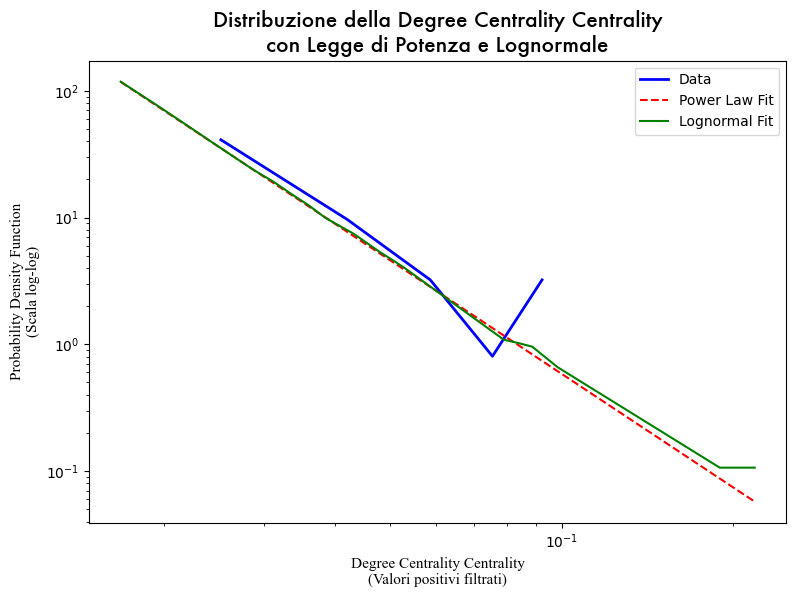

Calculating best minimal value for power law fit
Esponente della legge di potenza (Betweenness): 1.8577
p-value del fit della legge di potenza (Betweenness): 0.0708
Log-likelihood ratio test between power law and lognormal (Betweenness): -0.8204
p-value for the log-likelihood ratio test (Betweenness): 0.4362


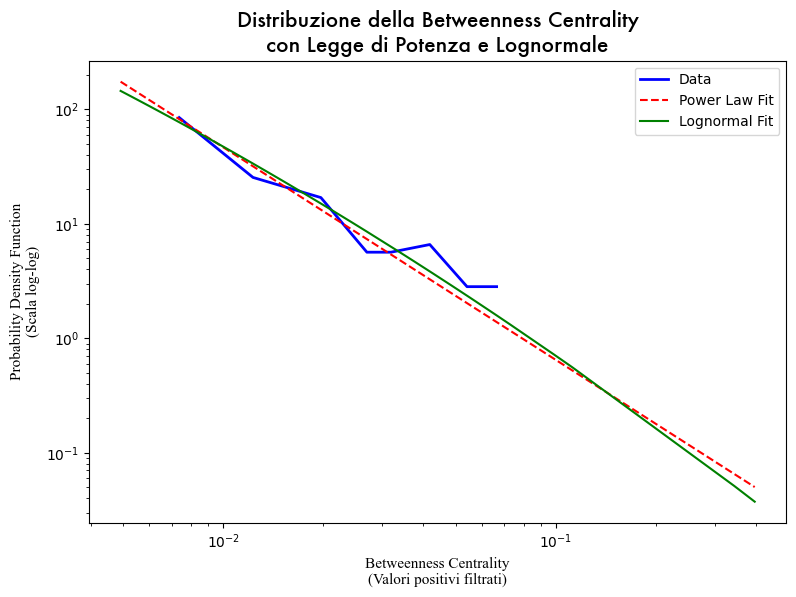

Calculating best minimal value for power law fit
Esponente della legge di potenza (Eigenvector): 2.6316
p-value del fit della legge di potenza (Eigenvector): 0.0463
Log-likelihood ratio test between power law and lognormal (Eigenvector): -0.4831
p-value for the log-likelihood ratio test (Eigenvector): 0.5342


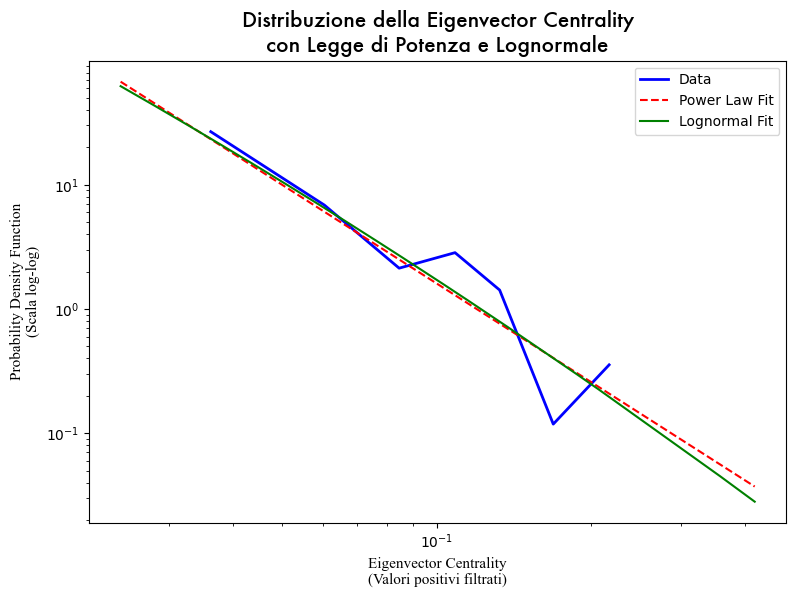

In [28]:
def analyze_centrality(centrality_values, centrality_name):
    # Filtra i valori positivi poiché la legge di potenza non può avere valori zero o negativi
    centrality_values = [v for v in centrality_values if v > 0]
    
    # Adatta i dati a una distribuzione di legge di potenza
    fit = powerlaw.Fit(centrality_values)
    
    # Stampa l'esponente stimato della legge di potenza
    power_law_alpha = fit.power_law.alpha
    power_law_D = fit.power_law.D
    print(f"Esponente della legge di potenza ({centrality_name}): {power_law_alpha:.4f}")
    print(f"p-value del fit della legge di potenza ({centrality_name}): {power_law_D:.4f}")
    
    # Confronto con altre distribuzioni
    R, p = fit.distribution_compare('power_law', 'lognormal')
    print(f"Log-likelihood ratio test between power law and lognormal ({centrality_name}): {R:.4f}")
    print(f"p-value for the log-likelihood ratio test ({centrality_name}): {p:.4f}")
    
    # Visualizza i dati e il fit
    plt.figure(figsize=(9, 6))  
    fig = fit.plot_pdf(color='b', linewidth=2, label='Data')
    fit.power_law.plot_pdf(color='r', linestyle='--', ax=fig, label='Power Law Fit')
    fit.lognormal.plot_pdf(color='g', linestyle='-', ax=fig, label='Lognormal Fit')
    plt.xlabel(f'{centrality_name} Centrality\n(Valori positivi filtrati)', fontsize=11, fontname='Times New Roman')
    plt.ylabel('Probability Density Function\n(Scala log-log)', fontsize=11, fontname='Times New Roman')
    plt.title(f'Distribuzione della {centrality_name} Centrality\ncon Legge di Potenza e Lognormale', 
              fontsize=15, fontweight='bold', fontname='Futura')
    plt.legend()
    plt.show()

# degree centrality
centrality_values = list(degree_centrality.values())
analyze_centrality(centrality_values, 'Degree Centrality')

# betweenness centrality
betweenness_values = list(betweenness_centrality.values())
analyze_centrality(betweenness_values, 'Betweenness')

# eigenvector centrality
eigenvector_values = list(eigenvector_centrality.values())
analyze_centrality(eigenvector_values, 'Eigenvector')


In [ ]:
# Ordina i nodi per betweenness centrality e prendi i primi 10
top_nodes_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
nodes_betweenness = [node for node, _ in top_nodes_betweenness]
centrality_values_betweenness = [value for _, value in top_nodes_betweenness]

# Plot a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(nodes_betweenness, centrality_values_betweenness, color='green', alpha=0.5)
plt.xlabel('Nodi')
plt.ylabel('Betweenness Centrality')
plt.title('Top 10 Betweenness Centrality dei Nodi')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Ordina i nodi per eigenvector centrality e prendi i primi 10
top_nodes_eigenvector = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
nodes_eigenvector = [node for node, _ in top_nodes_eigenvector]
centrality_values_eigenvector = [value for _, value in top_nodes_eigenvector]

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(centrality_values_eigenvector, labels=nodes_eigenvector, autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Eigenvector Centrality dei Nodi')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
# Ordina i nodi per closeness centrality e prendi i primi 10
top_nodes_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
nodes_closeness = [node for node, _ in top_nodes_closeness]
centrality_values_closeness = [value for _, value in top_nodes_closeness]

# Plot a line chart
plt.figure(figsize=(10, 6))
plt.plot(nodes_closeness, centrality_values_closeness, marker='o', linestyle='-', color='purple')
plt.xlabel('Nodi')
plt.ylabel('Closeness Centrality')
plt.title('Top 10 Closeness Centrality dei Nodi')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# SIMULAZIONE E TESTING

In [62]:
lista_parole = ['Roma', 'Milano', 'Bologna', 'Torino', 'Napoli']

df1 = pd.read_csv('./dataset/treni_solo_citta.csv')
# Filtra il DataFrame rimuovendo le righe che contengono almeno una delle parole dalla lista
filtered_df1 = df1[~df1['stazPart'].str.contains('|'.join(lista_parole), case=False, na=False)]
refiltered_df = filtered_df1[~filtered_df1['stazArr'].str.contains('|'.join(lista_parole), case=False, na=False)]
# salva file per fare calcoli delle misurazioni nella sezione che segue
refiltered_df.to_csv('./dataset/simulazione/treni_solo_citta-.csv', index=False)

df2 = pd.read_csv('./dataset/merged_data.csv')
# Filtra il DataFrame rimuovendo le righe che contengono almeno una delle parole dalla lista
filtered_df2 = df2[~df2['citta_uniche'].str.contains('|'.join(lista_parole), case=False, na=False)]
# salva file per fare calcoli delle misurazioni nella sezione che segue
filtered_df2.to_csv('./dataset/simulazione/merged_data-.csv', index=False)


df3 = pd.read_csv('./dataset/lista_citta_con_stazione.csv')
# Filtra il DataFrame rimuovendo le righe che contengono almeno una delle parole dalla lista
filtered_df3 = df3[~df3['citta_uniche'].str.contains('|'.join(lista_parole), case=False, na=False)]
# salva file per fare calcoli delle misurazioni nella sezione che segue
filtered_df3.to_csv('./dataset/simulazione/lista_citta_con_stazione-.csv', index=False)

In [ ]:
df_citta = pd.read_csv('./dataset/simulazione/merged_data-.csv')
df_coppie = pd.read_csv('./dataset/simulazione/treni_solo_citta-.csv')

# Mappa delle città ai loro set di coordinate
citta_coord = {}
for idx, row in df_citta.iterrows():
    citta_coord[row['citta_uniche']] = (row['LAT'], row['LON'])

m = folium.Map(location=[41.8719, 12.5674], zoom_start=6, zoom_control=True, scrollWheelZoom=True)
geojson_data = './italy.geojson'

folium.GeoJson(
    geojson_data,
    style_function=lambda feature: {
        'color': 'black',
        'weight': 0.7
    }
).add_to(m)

# Funzione per aggiungere un arco tra le città di partenza e arrivo
def aggiungi_arco(mappa, citta_partenza, citta_arrivo):
    coord_partenza = citta_coord.get(citta_partenza)
    coord_arrivo = citta_coord.get(citta_arrivo)
    
    if coord_partenza and coord_arrivo:
        folium.PolyLine(
            locations=[coord_partenza, coord_arrivo],
            color='grey',
            weight=0.05,
            opacity=1  
        ).add_to(mappa)

for idx, row in df_citta.iterrows():
    folium.CircleMarker(
        location=[row['LAT'], row['LON']],
        radius=1,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7  
    ).add_to(m)

# Aggiungi gli archi 
for idx, row in df_coppie.iterrows():
    aggiungi_arco(m, row['stazPart'], row['stazArr'])

m

In [ ]:
df_citta = pd.read_csv('./dataset/simulazione/lista_citta_con_stazione-.csv')
df_coppie = pd.read_csv('./dataset/simulazione/treni_solo_citta-.csv')

# grafo 2
G_2 = nx.Graph()

posizioni_usate = {}

# Aggiungi i nodi (città) al grafo con posizioni casuali non sovrapposte
for idx, row in df_citta.iterrows():
    while True:
        x = random.uniform(0, 1)  # Coordinate x casuali tra 0 e 1
        y = random.uniform(0, 1)  # Coordinate y casuali tra 0 e 1
        pos = (x, y)
        if pos not in posizioni_usate.values():
            posizioni_usate[row['citta_uniche']] = pos
            break
    G_2.add_node(row['citta_uniche'], pos=pos)

# Aggiungi gli archi (connessioni tra città di partenza e arrivo) al grafo
for idx, row in df_coppie.iterrows():
    G_2.add_edge(row['stazPart'], row['stazArr'])

G_2.remove_edges_from(nx.selfloop_edges(G_2))

# Calcolo delle misurazioni di centralità e altre metriche
degree_centrality_2 = nx.degree_centrality(G_2)
betweenness_centrality_2 = nx.betweenness_centrality(G_2)
eigenvector_centrality_2 = nx.eigenvector_centrality(G_2, max_iter=1000)
closeness_centrality_2 = nx.closeness_centrality(G_2)
clustering_coefficient_2 = nx.clustering(G_2)
density_2 = nx.density(G_2)

if nx.is_connected(G_2):
    avg_path_length = nx.average_shortest_path_length(G_2)
    diameter = nx.diameter(G_2)
else:
    avg_path_length = None
    diameter = None

connected_components_2 = list(nx.connected_components(G_2))
connectedness_2 = len(connected_components_2)

core_number_2 = nx.core_number(G_2)
assortativity_2 = nx.degree_assortativity_coefficient(G_2)
bridges_2 = list(nx.bridges(G_2))

# Stampa delle metriche
print("Degree Centrality:", degree_centrality_2)
print("Betweenness Centrality:", betweenness_centrality_2)
print("Eigenvector Centrality:", eigenvector_centrality_2)
print("Closeness Centrality:", closeness_centrality_2)
print("Clustering Coefficient:", clustering_coefficient_2)
print("Density:", density_2)
print("Number of Connected Components:", connectedness_2)
print("Core Numbers:", core_number_2)
print("Assortativity:", assortativity_2)
print("Bridges:", bridges_2)

In [ ]:
# Ordina i nodi per degree centrality e prendi i primi 10
top_nodes_degree = sorted(degree_centrality_2.items(), key=lambda x: x[1], reverse=True)[:10]
nodes_degree = [node for node, _ in top_nodes_degree]
centrality_values_degree = [value for _, value in top_nodes_degree]

# Plot a bar chart
plt.figure(figsize=(12, 6))
plt.bar(nodes_degree, centrality_values_degree, color='skyblue')
plt.xlabel('Nodi')
plt.ylabel('Degree Centrality')
plt.title('Top 10 Degree Centrality dei Nodi')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Ordina i nodi per betweenness centrality e prendi i primi 10
top_nodes_betweenness = sorted(betweenness_centrality_2.items(), key=lambda x: x[1], reverse=True)[:10]
nodes_betweenness = [node for node, _ in top_nodes_betweenness]
centrality_values_betweenness = [value for _, value in top_nodes_betweenness]

# Plot a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(nodes_betweenness, centrality_values_betweenness, color='green', alpha=0.5)
plt.xlabel('Nodi')
plt.ylabel('Betweenness Centrality')
plt.title('Top 10 Betweenness Centrality dei Nodi')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Ordina i nodi per eigenvector centrality e prendi i primi 10
top_nodes_eigenvector = sorted(eigenvector_centrality_2.items(), key=lambda x: x[1], reverse=True)[:10]
nodes_eigenvector = [node for node, _ in top_nodes_eigenvector]
centrality_values_eigenvector = [value for _, value in top_nodes_eigenvector]

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(centrality_values_eigenvector, labels=nodes_eigenvector, autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Eigenvector Centrality dei Nodi')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
# Ordina i nodi per closeness centrality e prendi i primi 10
top_nodes_closeness = sorted(closeness_centrality_2.items(), key=lambda x: x[1], reverse=True)[:10]
nodes_closeness = [node for node, _ in top_nodes_closeness]
centrality_values_closeness = [value for _, value in top_nodes_closeness]

# Plot a line chart
plt.figure(figsize=(10, 6))
plt.plot(nodes_closeness, centrality_values_closeness, marker='o', linestyle='-', color='purple')
plt.xlabel('Nodi')
plt.ylabel('Closeness Centrality')
plt.title('Top 10 Closeness Centrality dei Nodi')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# TODO CHECKLIST

- capire bene i risultati